## Lead Scoring 
We have leads being generated by many online platforms and we need to predict which lead is highly likely to convert 

In [594]:
## Importing the necessary libraries

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve,f1_score

In [595]:
## Reading the data

lead= pd.read_csv('Leads.csv')
lead.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit  ...  \
0                            0                   0.0  ...   
1                          674                   2.5  ...   
2                         1532                   2.0  ...   
3                          305                   1.0  ...   
4                         1428                   1.0  ...   

  Get updates on DM Content    Lead Profile    City  \
0                        No          Select  Select   
1                        No          Select  Select   
2                        No  Potential Lead  Mumbai   
3                        No          Select  Mumbai   
4                        No          Select  Mumbai   

  Asymmetrique Activity Index Asymmetrique Profile Index  \
0                   02.Medium                  02.Medium   
1                   02.Medium                  02.Medium   
2                   02.Medium                    01.High   
3                   02.Medium                    01.High   
4                   02.Medium                    01.High   

  Asymmetrique Activity Score Asymmetrique Profile Score  \
0                        15.0                       15.0   
1                        15.0                       15.0   
2                        14.0                       20.0   
3                        13.0                       17.0   
4                        15.0                       18.0   

  I agree to pay the amount through cheque  \
0                                       No   
1                                       No   
2                                       No   
3                                       No   
4                                       No   

  A free copy of Mastering The Interview Last Notable Activity  
0                                     No              Modified  
1                                     No          Email Opened  
2                                    Yes          Email Opened  
3                                     No              Modified  
4                                     No              Modified  

[5 rows x 37 columns]

In [596]:
lead.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   7802 

In [597]:
## Checking imbalance of data

lead['Converted'].value_counts(normalize=True)

0    0.61461
1    0.38539
Name: Converted, dtype: float64

In [598]:
lead.shape

(9240, 37)

In [599]:
## Replacing the 'select' with np.Nan

lead['Specialization'].replace(to_replace='Select', value= np.NaN,inplace=True)
lead['How did you hear about X Education'].replace(to_replace='Select', value= np.NaN,inplace=True)
lead['Lead Profile'].replace(to_replace='Select', value= np.NaN,inplace=True)
lead['City'].replace(to_replace='Select', value= np.NaN,inplace=True)

## EDA

In [600]:
# correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(lead.corr(),annot = True)
plt.show()

## Univariate Analysis

- The Maximum visits are from the candidates whose "Specialization" is "Finance Management"
- The maximum number of visitors are through the "Google" search source
- The maximum number of visitors are of "Unemployed" category

In [601]:
plt.figure(figsize=(30,20))
plt.subplot(1,3,1)
lead['Specialization'].value_counts(normalize=True).plot.barh(align='center')
plt.subplot(1,3,2)
lead['Lead Source'].value_counts(normalize=True).plot.barh(align='center')
plt.subplot(1,3,3)
lead['What is your current occupation'].value_counts(normalize=True).plot.barh(align='center')
plt.show()

In [602]:
## Pie chart to find the proportion of Converted records

lead['Converted'].value_counts(normalize=True).plot.pie()
plt.show()

## Finding categories with conversion

- Finance Management leads are the maximum who get converted
- Leads through Google search are those who get converted to payed members to a maximum extent
- Unemployed leads are potential candidates for conversion

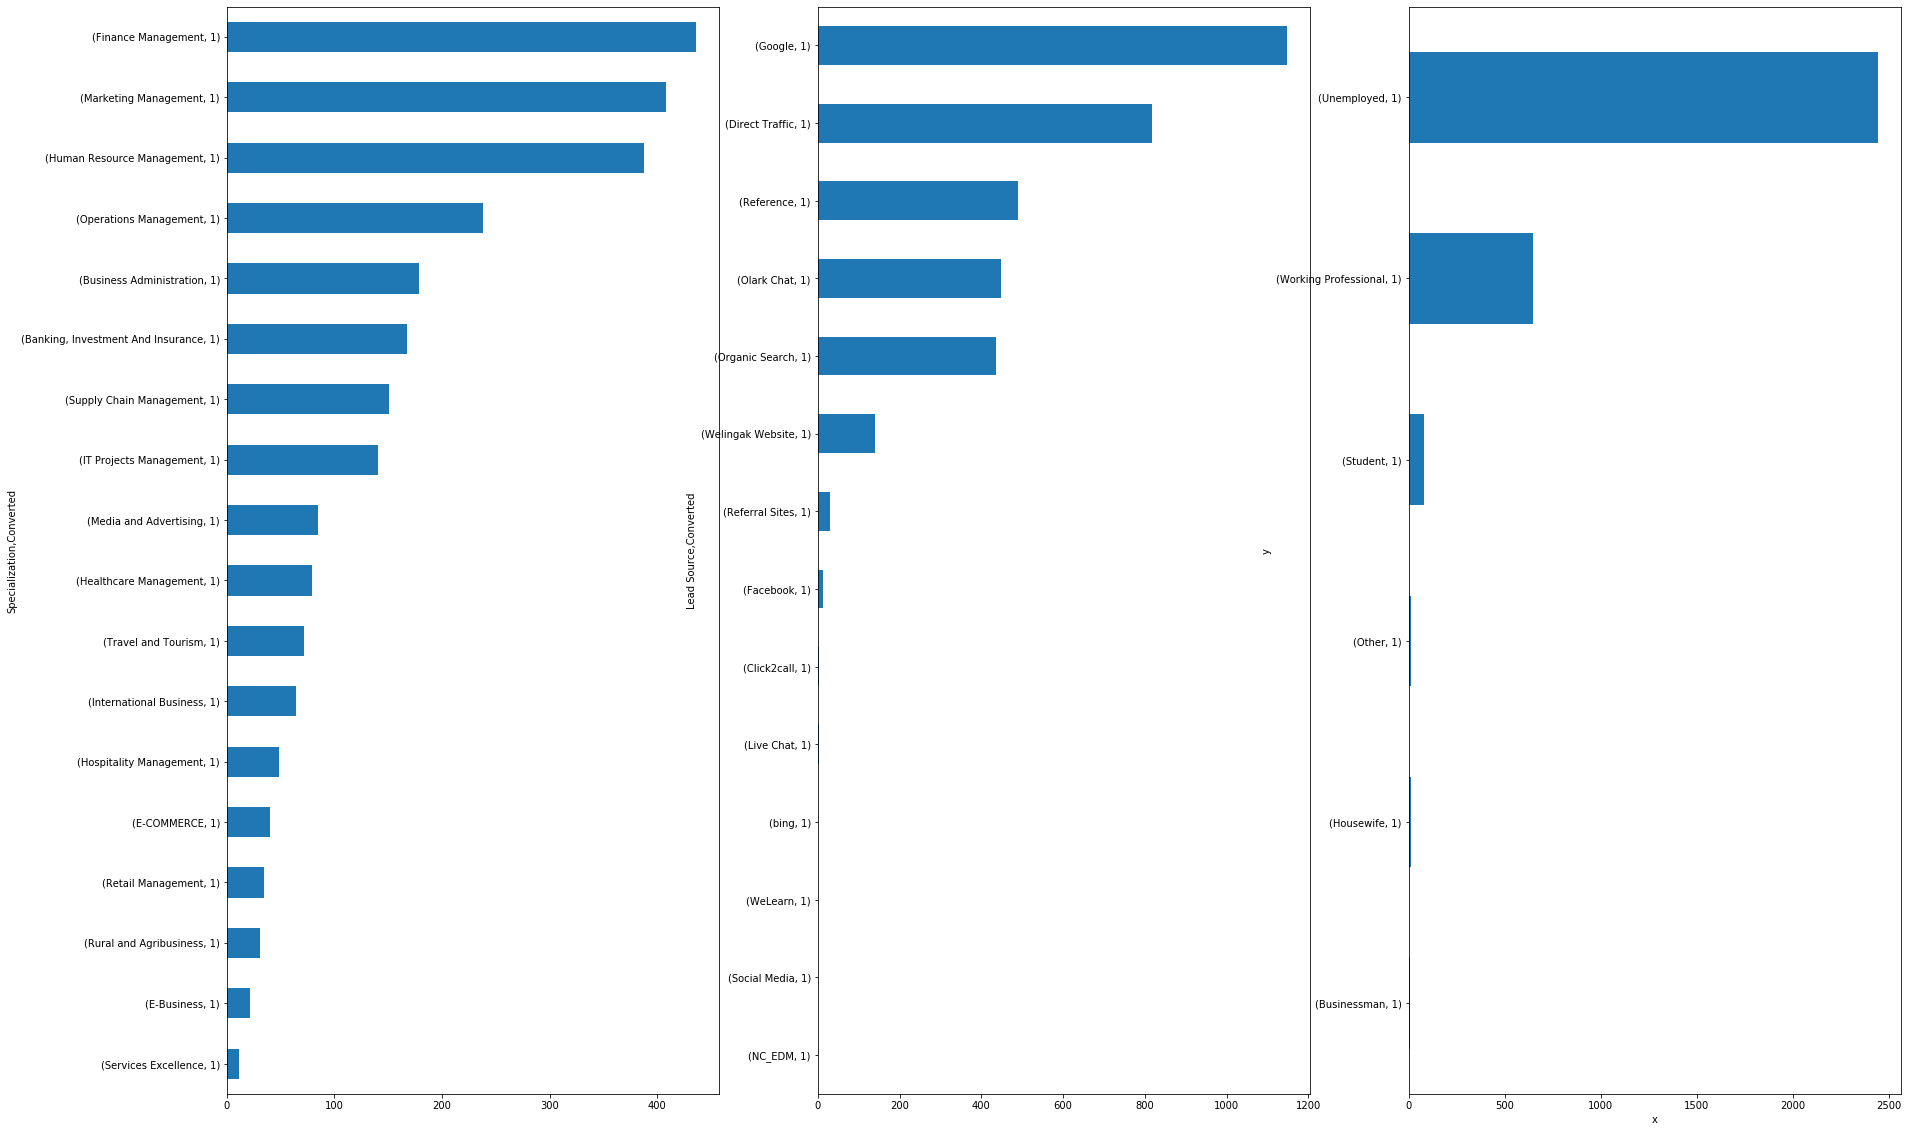

In [603]:
plt.figure(figsize=(30,20))
plt.subplot(1,3,1)
lead[lead.Converted == 1].groupby(['Specialization'])['Converted'].value_counts().sort_values(ascending=True).plot.barh()
plt.subplot(1,3,2)
lead[lead.Converted == 1].groupby(['Lead Source'])['Converted'].value_counts().sort_values(ascending=True).plot.barh()
plt.subplot(1,3,3)
lead[lead.Converted == 1].groupby(['What is your current occupation'])['Converted'].value_counts().sort_values(ascending=True).plot.barh()

plt.xlabel('x')
plt.ylabel('y')      
plt.show()

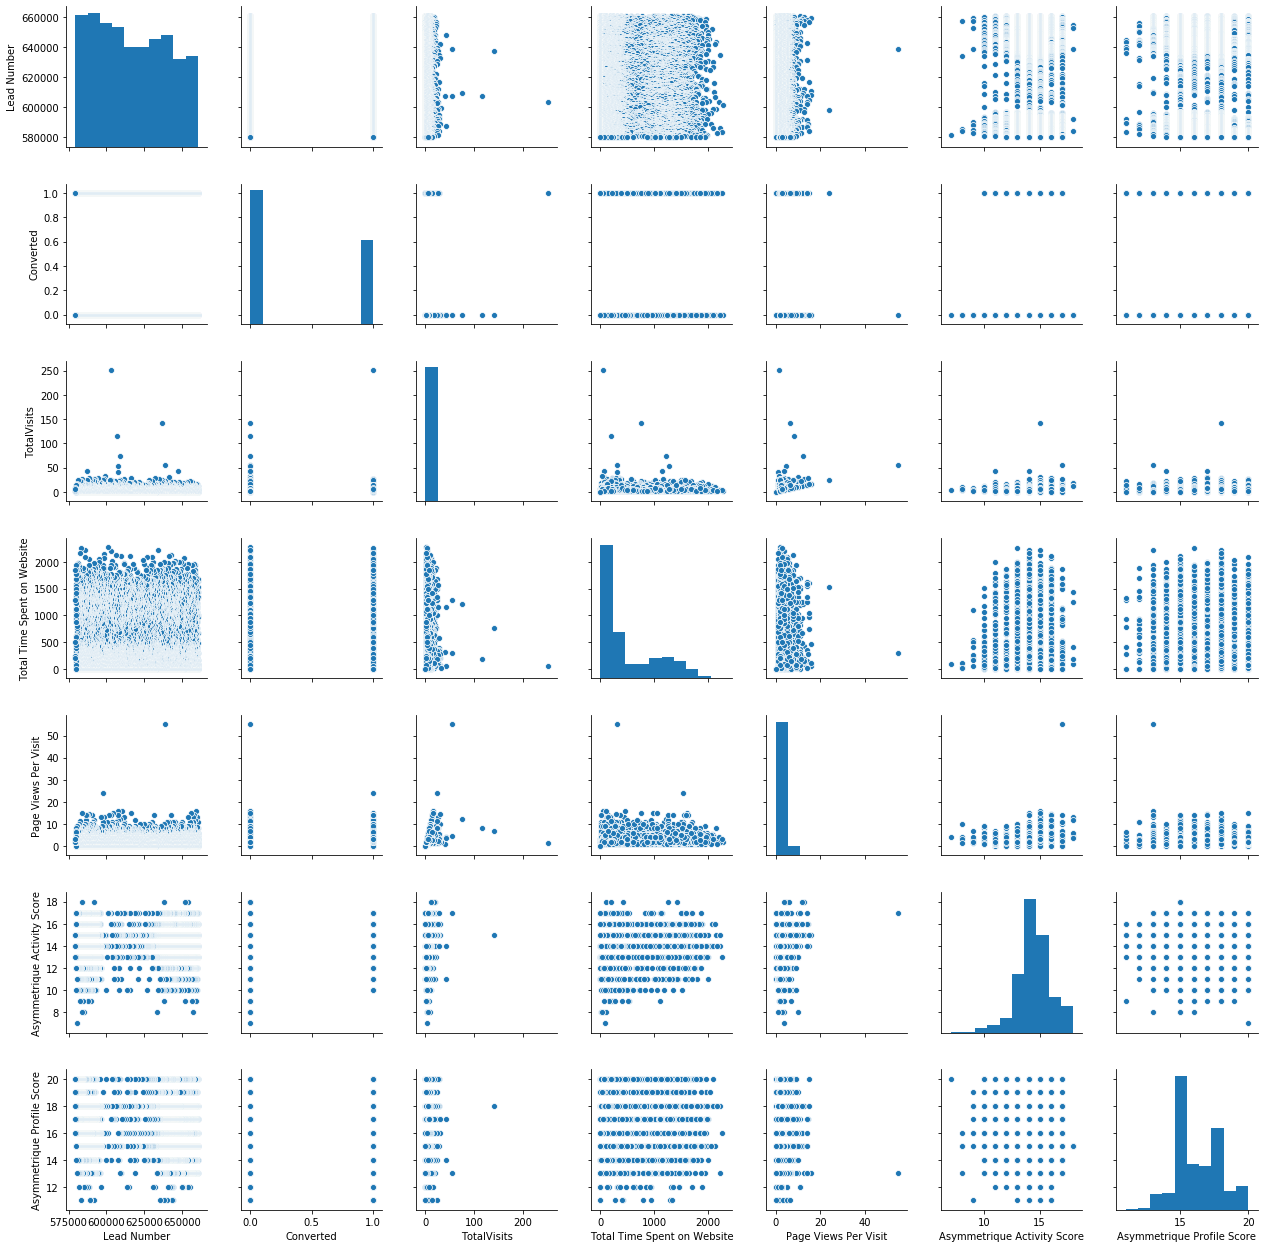

In [604]:
## Visualization of numeric varibale

sns.pairplot(lead)
plt.show()

In [605]:
## Drop the columns with more than 50% of null values

missing_percentage= pd.DataFrame({'Column_name': lead.columns, 'Percentage': round(lead.isnull().sum()/len(lead)*100,2)})



In [606]:
cols_to_drop= list(missing_percentage[missing_percentage['Percentage']>50]['Column_name'])
cols_to_drop

['How did you hear about X Education', 'Lead Quality', 'Lead Profile']

In [607]:
## Droppping columns 

lead.drop(cols_to_drop,axis=1,inplace=True)


In [608]:
lead.shape

(9240, 34)

In [609]:
## Dropping rows with more than 5 missing fields 

row_grt5= lead[(lead.isnull().sum(axis=1)>5)]
row_grt5

Prospect ID  Lead Number Lead Origin  \
5     2058ef08-2858-443e-a01f-a9237db2f5ce       660680         API   
7     20ef72a2-fb3b-45e0-924e-551c5fa59095       660664         API   
16    3abb7c77-1634-4083-9a9f-861068220611       660540         API   
47    3f04fd93-2884-45f6-a4fc-f3b6f234554b       660153         API   
49    319325b3-50b3-45d0-b730-c9df0b30b9ea       660128         API   
...                                    ...          ...         ...   
9154  f0d6b8f3-d1bf-4ea4-a712-2249fc46b3a1       580264         API   
9165  94227774-002b-451c-92ec-364f4d29de3c       580181         API   
9183  bc77b8ab-253a-443d-802b-d023f8f44ef8       580017         API   
9187  4f465f71-1946-414e-9716-4847c60606e8       579979         API   
9233  3f715465-2546-47cd-afa8-8b8dc63b8b43       579622         API   

         Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
5         Olark Chat           No          No          0          0.0   
7         Olark Chat           No          No          0          0.0   
16        Olark Chat           No          No          0          0.0   
47        Olark Chat           No          No          0          0.0   
49        Olark Chat           No          No          0          0.0   
...              ...          ...         ...        ...          ...   
9154      Olark Chat           No          No          0          1.0   
9165      Olark Chat           No          No          1          0.0   
9183          Google           No          No          0          4.0   
9187      Olark Chat           No          No          1          0.0   
9233  Direct Traffic           No          No          1         13.0   

      Total Time Spent on Website  Page Views Per Visit  ...  \
5                               0                   0.0  ...   
7                               0                   0.0  ...   
16                              0                   0.0  ...   
47                              0                   0.0  ...   
49                              0                   0.0  ...   
...                           ...                   ...  ...   
9154                         1858                   1.0  ...   
9165                            0                   0.0  ...   
9183                          952                   2.0  ...   
9187                            0                   0.0  ...   
9233                         1409                   2.6  ...   

     Update me on Supply Chain Content Get updates on DM Content City  \
5                                   No                        No  NaN   
7                                   No                        No  NaN   
16                                  No                        No  NaN   
47                                  No                        No  NaN   
49                                  No                        No  NaN   
...                                ...                       ...  ...   
9154                                No                        No  NaN   
9165                                No                        No  NaN   
9183                                No                        No  NaN   
9187                                No                        No  NaN   
9233                                No                        No  NaN   

     Asymmetrique Activity Index Asymmetrique Profile Index  \
5                        01.High                  02.Medium   
7                      02.Medium                  02.Medium   
16                       01.High                  02.Medium   
47                       01.High                  02.Medium   
49                       01.High                  02.Medium   
...                          ...                        ...   
9154                   02.Medium                  02.Medium   
9165                     01.High                  02.Medium   
9183                         NaN                        NaN   
9187                     

In [610]:
list_of_indices= row_grt5.index.tolist()

In [611]:
lead.drop(list_of_indices,axis=0,inplace=True)

In [612]:
##retained rows are 6552

lead.shape

(6552, 34)

In [613]:
## Finding unique values in the columns: Looks like there are no single unnique values in the columns, there are
#multiple category of values in columns:

unique=[]

for col in lead:
    if lead[col].nunique==1:
        unique.append(col)

unique

[]

In [614]:
## Creating the list of catergorical columns

cat_cols= [col for col in lead.columns if lead[col].dtype=='object']
cat_cols

['Prospect ID',
 'Lead Origin',
 'Lead Source',
 'Do Not Email',
 'Do Not Call',
 'Last Activity',
 'Country',
 'Specialization',
 'What is your current occupation',
 'What matters most to you in choosing a course',
 'Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Tags',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'City',
 'Asymmetrique Activity Index',
 'Asymmetrique Profile Index',
 'I agree to pay the amount through cheque',
 'A free copy of Mastering The Interview',
 'Last Notable Activity']

In [615]:
##Binning the column categories whose percentages are less than 10%, so that we can reduce on number of features.

for col in cat_cols:
    df = lead[col].value_counts()/len(lead)*100<10
    bin_data = df[df.values==True].index.tolist()
    lead[col] = lead[col].apply(lambda x: 'others' if x in bin_data else x)

In [616]:
## Checking the skewness of the cat cols , Code marke ##-- are the once with highly skewed category

print(lead['Lead Origin'].value_counts()/len(lead)*100)
print(lead['Lead Source'].value_counts()/len(lead)*100) 
print(lead['Do Not Email'].value_counts()/len(lead)*100)##---
print(lead['Do Not Call'].value_counts()/len(lead)*100)##----
print(lead['Last Activity'].value_counts()/len(lead)*100)
print(lead['Country'].value_counts()/len(lead)*100)##----
print(lead['Specialization'].value_counts()/len(lead)*100)
print(lead['What is your current occupation'].value_counts()/len(lead)*100)
print(lead['What matters most to you in choosing a course'].value_counts()/len(lead)*100)##----
print(lead['Search'].value_counts()/len(lead)*100)
print(lead['Magazine'].value_counts()/len(lead)*100)###--
print(lead['Newspaper Article'].value_counts()/len(lead)*100)##---
print(lead['X Education Forums'].value_counts()/len(lead)*100)##-----
print(lead['Newspaper'].value_counts()/len(lead)*100)###----
print(lead['Digital Advertisement'].value_counts()/len(lead)*100)##----
print(lead['Through Recommendations'].value_counts()/len(lead)*100)##----
print(lead['Receive More Updates About Our Courses'].value_counts()/len(lead)*100)##-----
print(lead['Tags'].value_counts()/len(lead)*100)
print(lead['Update me on Supply Chain Content'].value_counts()/len(lead)*100)##--
print(lead['Get updates on DM Content'].value_counts()/len(lead)*100)###---
print(lead['City'].value_counts()/len(lead)*100)
print(lead['Asymmetrique Activity Index'].value_counts()/len(lead)*100)
print(lead['Asymmetrique Profile Index'].value_counts()/len(lead)*100)
print(lead['I agree to pay the amount through cheque'].value_counts()/len(lead)*100)###---
print(lead['A free copy of Mastering The Interview'].value_counts()/len(lead)*100)
print(lead['Last Notable Activity'].value_counts()/len(lead)*100)

    

Landing Page Submission    65.094628
API                        27.640415
others                      7.264957
Name: Lead Origin, dtype: float64
Google            35.103785
Direct Traffic    32.921245
others            17.567155
Organic Search    14.163614
Name: Lead Source, dtype: float64
No        92.628205
others     7.371795
Name: Do Not Email, dtype: float64
No        99.969475
others     0.030525
Name: Do Not Call, dtype: float64
Email Opened    40.064103
SMS Sent        30.860806
others          28.434066
Name: Last Activity, dtype: float64
India     81.807082
others     3.571429
Name: Country, dtype: float64
others                       42.735043
Finance Management           12.973138
Human Resource Management    11.202686
Marketing Management         10.943223
Name: Specialization, dtype: float64
Unemployed    72.710623
others        11.828449
Name: What is your current occupation, dtype: float64
Better Career Prospects    84.432234
others                      0.045788
Name: W

In [617]:
## Dropping columns with high skewness from the above numbers

lead.drop(['Do Not Email','Do Not Call','Country','What matters most to you in choosing a course','Magazine','Newspaper Article',
          'X Education Forums','Newspaper','Digital Advertisement','Through Recommendations','Receive More Updates About Our Courses',
           'Update me on Supply Chain Content','Search','Get updates on DM Content','I agree to pay the amount through cheque'],axis=1,inplace=True)

In [618]:
lead.shape

(6552, 19)

In [619]:
cat_cols= [col for col in lead.columns if lead[col].dtype=='object']
cat_cols

['Prospect ID',
 'Lead Origin',
 'Lead Source',
 'Last Activity',
 'Specialization',
 'What is your current occupation',
 'Tags',
 'City',
 'Asymmetrique Activity Index',
 'Asymmetrique Profile Index',
 'A free copy of Mastering The Interview',
 'Last Notable Activity']

In [620]:
num_cols= [col for col in lead.columns if lead[col].dtype=='int' or lead[col].dtype=='float' ]
num_cols

['Lead Number',
 'Converted',
 'TotalVisits',
 'Total Time Spent on Website',
 'Page Views Per Visit',
 'Asymmetrique Activity Score',
 'Asymmetrique Profile Score']

In [621]:
## Converting the Yes as 1 and No as 0

varlist =  ['A free copy of Mastering The Interview']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the housing list
lead[varlist] = lead[varlist].apply(binary_map)

In [622]:
##Converting the above binary converted to object dtype

lead['A free copy of Mastering The Interview']=lead['A free copy of Mastering The Interview'].astype('object')

In [623]:
## Creating dummies:


dummy1 = pd.get_dummies(lead[['Lead Origin', 'Lead Source','Last Activity','Specialization','What is your current occupation',
                             'Tags','City','Asymmetrique Activity Index','Asymmetrique Profile Index',
                             'Last Notable Activity']], drop_first=True)

In [624]:
##concat the lead DF with dummy

lead= pd.concat([lead,dummy1],axis=1)

In [625]:
## Drop the original columns of dummies

lead.drop(['Lead Origin', 'Lead Source','Last Activity','Specialization','What is your current occupation',
                             'Tags','City','Asymmetrique Activity Index','Asymmetrique Profile Index',
                             'Last Notable Activity'],axis=1,inplace=True)

In [626]:
lead.shape

(6552, 30)

In [627]:
## Computing missing values

round((lead.isnull().sum()/len(lead)),2)

Prospect ID                                 0.00
Lead Number                                 0.00
Converted                                   0.00
TotalVisits                                 0.01
Total Time Spent on Website                 0.00
Page Views Per Visit                        0.01
Asymmetrique Activity Score                 0.30
Asymmetrique Profile Score                  0.30
A free copy of Mastering The Interview      0.00
Lead Origin_Landing Page Submission         0.00
Lead Origin_others                          0.00
Lead Source_Google                          0.00
Lead Source_Organic Search                  0.00
Lead Source_others                          0.00
Last Activity_SMS Sent                      0.00
Last Activity_others                        0.00
Specialization_Human Resource Management    0.00
Specialization_Marketing Management         0.00
Specialization_others                       0.00
What is your current occupation_others      0.00
Tags_Will revert aft

In [628]:
lead.describe()

Lead Number    Converted  TotalVisits  Total Time Spent on Website  \
count    6552.000000  6552.000000  6493.000000                  6552.000000   
mean   618404.154762     0.427045     4.058525                   569.482448   
std     25681.527655     0.494687     5.101311                   555.964542   
min    579533.000000     0.000000     0.000000                     0.000000   
25%    592790.500000     0.000000     2.000000                    96.000000   
50%    617849.500000     0.000000     3.000000                   334.000000   
75%    642063.000000     1.000000     5.000000                  1049.000000   
max    660737.000000     1.000000   251.000000                  2272.000000   

       Page Views Per Visit  Asymmetrique Activity Score  \
count           6493.000000                  4574.000000   
mean               2.771600                    14.136205   
std                2.122172                     1.275014   
min                0.000000                     7.000000   
25%                1.670000                    14.000000   
50%                2.330000                    14.000000   
75%                4.000000                    15.000000   
max               55.000000                    18.000000   

       Asymmetrique Profile Score  Lead Origin_Landing Page Submission  \
count                 4574.000000                          6552.000000   
mean                    16.472234                             0.650946   
std                      1.846147                             0.476707   
min                     11.000000                             0.000000   
25%                     15.000000                             0.000000   
50%                     16.000000                             1.000000   
75%                     18.000000                             1.000000   
max                     20.000000                             1.000000   

       Lead Origin_others  Lead Source_Google  ...  \
count          6552.00000         6552.000000  ...   
mean              0.07265            0.351038  ...   
std               0.25958            0.477331  ...   
min               0.00000            0.000000  ...   
25%               0.00000            0.000000  ...   
50%               0.00000            0.000000  ...   
75%               0.00000            1.000000  ...   
max               1.00000            1.000000  ...   

       Tags_Will revert after reading the email  Tags_others  \
count                               6552.000000  6552.000000   
mean                                   0.281136     0.338370   
std                                    0.449588     0.473191   
min                                    0.000000     0.000000   
25%                                    0.000000     0.000000   
50%                                    0.000000     0.000000   
75%                                    1.000000     1.000000   
max                                    1.000000     1.000000   

       City_Thane & Outskirts  City_others  \
count             6552.000000  6552.000000   
mean                 0.102259     0.212759   
std                  0.303012     0.409290   
min                  0.000000     0.000000   
25%                  0.000000     0.000000   
50%                  0.000000     0.000000   
75%                  0.000000     0.000000   
max                  1.000000     1.000000   

       Asymmetrique Activity Index_others  \
count                         6552.000000   
mean                             0.130952   
std                              0.337374   
min                              0.000000   
25%                              0.000000   
50%                              0.000000   
75%                              0.000000   
max                              1.000000   

       Asymmetrique Profile Index_02.Medium  \
count                           6552.000000   
mean                               0.358516   
std                                0.479601   
min             

## Splitting train and test Data

In [629]:
lead.columns

Index(['Prospect ID', 'Lead Number', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit',
       'Asymmetrique Activity Score', 'Asymmetrique Profile Score',
       'A free copy of Mastering The Interview',
       'Lead Origin_Landing Page Submission', 'Lead Origin_others',
       'Lead Source_Google', 'Lead Source_Organic Search',
       'Lead Source_others', 'Last Activity_SMS Sent', 'Last Activity_others',
       'Specialization_Human Resource Management',
       'Specialization_Marketing Management', 'Specialization_others',
       'What is your current occupation_others',
       'Tags_Will revert after reading the email', 'Tags_others',
       'City_Thane & Outskirts', 'City_others',
       'Asymmetrique Activity Index_others',
       'Asymmetrique Profile Index_02.Medium',
       'Asymmetrique Profile Index_others', 'Last Notable Activity_Modified',
       'Last Notable Activity_SMS Sent', 'Last Notable Activity_others'],
      dtype='object')

In [630]:
X = lead.drop(['Prospect ID','Lead Number','Converted'], axis=1)

X.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                            0                   0.0   
1          5.0                          674                   2.5   
2          2.0                         1532                   2.0   
3          1.0                          305                   1.0   
4          2.0                         1428                   1.0   

   Asymmetrique Activity Score  Asymmetrique Profile Score  \
0                         15.0                        15.0   
1                         15.0                        15.0   
2                         14.0                        20.0   
3                         13.0                        17.0   
4                         15.0                        18.0   

  A free copy of Mastering The Interview  Lead Origin_Landing Page Submission  \
0                                      0                                    0   
1                                      0                                    0   
2                                      1                                    1   
3                                      0                                    1   
4                                      0                                    1   

   Lead Origin_others  Lead Source_Google  Lead Source_Organic Search  ...  \
0                   0                   0                           0  ...   
1                   0                   0                           1  ...   
2                   0                   0                           0  ...   
3                   0                   0                           0  ...   
4                   0                   1                           0  ...   

   Tags_Will revert after reading the email  Tags_others  \
0                                         0            1   
1                                         0            0   
2                                         1            0   
3                                         0            0   
4                                         1            0   

   City_Thane & Outskirts  City_others  Asymmetrique Activity Index_others  \
0                       0            0                                   0   
1                       0            0                                   0   
2                       0            0                                   0   
3                       0            0                                   0   
4                       0            0                                   0   

   Asymmetrique Profile Index_02.Medium  Asymmetrique Profile Index_others  \
0                                     1                                  0   
1                                     1                                  0   
2                                     0                                  0   
3                                     0                                  0   
4                                     0                                  0   

   Last Notable Activity_Modified  Last Notable Activity_SMS Sent  \
0                               1                               0   
1                               0                               0   
2                               0                               0   
3                               1                               0   
4                               1                               0   

   Last Notable Activity_others  
0                             0  
1                             0  
2                             0  
3                             0  
4                             0  

[5 rows x 27 columns]

In [631]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6552 entries, 0 to 9239
Data columns (total 27 columns):
TotalVisits                                 6493 non-null float64
Total Time Spent on Website                 6552 non-null int64
Page Views Per Visit                        6493 non-null float64
Asymmetrique Activity Score                 4574 non-null float64
Asymmetrique Profile Score                  4574 non-null float64
A free copy of Mastering The Interview      6552 non-null object
Lead Origin_Landing Page Submission         6552 non-null uint8
Lead Origin_others                          6552 non-null uint8
Lead Source_Google                          6552 non-null uint8
Lead Source_Organic Search                  6552 non-null uint8
Lead Source_others                          6552 non-null uint8
Last Activity_SMS Sent                      6552 non-null uint8
Last Activity_others                        6552 non-null uint8
Specialization_Human Resource Management    6552 non

In [632]:
y=lead['Converted']

y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [633]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [634]:
# Filling the missing values

for col in X_train.columns:
    if X_train[col].dtype=='object':
        X_train[col]=X_train[col].fillna(X_train[col].mode()[0]).astype(object)
        X_test[col]=X_test[col].fillna(X_train[col].mode()[0]).astype(object)
    else:
        X_train[col]=X_train[col].fillna(X_train[col].mean())
        X_test[col]=X_test[col].fillna(X_train[col].mean())



In [635]:
X_train.isnull().sum()

TotalVisits                                 0
Total Time Spent on Website                 0
Page Views Per Visit                        0
Asymmetrique Activity Score                 0
Asymmetrique Profile Score                  0
A free copy of Mastering The Interview      0
Lead Origin_Landing Page Submission         0
Lead Origin_others                          0
Lead Source_Google                          0
Lead Source_Organic Search                  0
Lead Source_others                          0
Last Activity_SMS Sent                      0
Last Activity_others                        0
Specialization_Human Resource Management    0
Specialization_Marketing Management         0
Specialization_others                       0
What is your current occupation_others      0
Tags_Will revert after reading the email    0
Tags_others                                 0
City_Thane & Outskirts                      0
City_others                                 0
Asymmetrique Activity Index_others

## Feature Scaling

In [636]:
scaler = StandardScaler()

X_train[[ 'TotalVisits','Total Time Spent on Website','Page Views Per Visit',
         'Asymmetrique Activity Score','Asymmetrique Profile Score']]=scaler.fit_transform(X_train[[ 'TotalVisits','Total Time Spent on Website','Page Views Per Visit',
                                                              'Asymmetrique Activity Score','Asymmetrique Profile Score']])

## Performing RFE 

In [637]:
logreg = LogisticRegression()

In [638]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 15)             
rfe = rfe.fit(X_train, y_train)

In [639]:
rfe.support_

array([False,  True, False,  True,  True, False,  True,  True, False,
       False,  True, False,  True, False, False, False,  True,  True,
        True, False, False,  True,  True,  True, False,  True,  True])

In [640]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('TotalVisits', False, 6),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 5),
 ('Asymmetrique Activity Score', True, 1),
 ('Asymmetrique Profile Score', True, 1),
 ('A free copy of Mastering The Interview', False, 12),
 ('Lead Origin_Landing Page Submission', True, 1),
 ('Lead Origin_others', True, 1),
 ('Lead Source_Google', False, 3),
 ('Lead Source_Organic Search', False, 4),
 ('Lead Source_others', True, 1),
 ('Last Activity_SMS Sent', False, 2),
 ('Last Activity_others', True, 1),
 ('Specialization_Human Resource Management', False, 10),
 ('Specialization_Marketing Management', False, 8),
 ('Specialization_others', False, 9),
 ('What is your current occupation_others', True, 1),
 ('Tags_Will revert after reading the email', True, 1),
 ('Tags_others', True, 1),
 ('City_Thane & Outskirts', False, 11),
 ('City_others', False, 7),
 ('Asymmetrique Activity Index_others', True, 1),
 ('Asymmetrique Profile Index_02.Medium', True, 1),
 ('Asymmetrique Profile 

In [641]:
col = X_train.columns[rfe.support_]
col

Index(['Total Time Spent on Website', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score', 'Lead Origin_Landing Page Submission',
       'Lead Origin_others', 'Lead Source_others', 'Last Activity_others',
       'What is your current occupation_others',
       'Tags_Will revert after reading the email', 'Tags_others',
       'Asymmetrique Activity Index_others',
       'Asymmetrique Profile Index_02.Medium',
       'Asymmetrique Profile Index_others', 'Last Notable Activity_SMS Sent',
       'Last Notable Activity_others'],
      dtype='object')

In [642]:
X_train.columns[~rfe.support_]

Index(['TotalVisits', 'Page Views Per Visit',
       'A free copy of Mastering The Interview', 'Lead Source_Google',
       'Lead Source_Organic Search', 'Last Activity_SMS Sent',
       'Specialization_Human Resource Management',
       'Specialization_Marketing Management', 'Specialization_others',
       'City_Thane & Outskirts', 'City_others',
       'Last Notable Activity_Modified'],
      dtype='object')

## Model Building

In [643]:
X_train_sm = sm.add_constant(X_train[col])
logm = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 4586
Model:                            GLM   Df Residuals:                     4570
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1305.3
Date:                Mon, 01 Jun 2020   Deviance:                       2610.6
Time:                        18:01:07   Pearson chi2:                 5.79e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -1.7427      0.188     -9.289      0.000      -2.110      -1.375
Total Time Spent on Website                  1.0605      0.055     19.383      0.000       0.953       1.168
Asymmetrique Activity Score                  0.8896      0.072     12.398      0.000       0.749       1.030
Asymmetrique Profile Score                   0.5079      0.084      6.017      0.000       0.342       0.673
Lead Origin_Landing Page Submission         -0.6544      0.161     -4.068      0.000      -0.970      -0.339
Lead Origin_others                           1.8566      0.240      7.730      0.000       1.386       2.327
Lead Source_others                           0.8861      0.184      4.823      0.000       0.526       1.246
Last Activity_others                        -1.2231      0.147     -8.293      0.000      -1.512      -0.934
What is your current occupation_others       0.6658      0.194      3.429      0.001       0.285       1.046
Tags_Will revert after reading the email     4.8545      0.202     24.077      0.000       4.459       5.250
Tags_others                                  0.5387      0.113      4.766      0.000       0.317       0.760
Asymmetrique Activity Index_others          -0.8675      0.189     -4.598      0.000      -1.237      -0.498
Asymmetrique Profile Index_02.Medium         0.6106      0.181      3.366      0.001       0.255       0.966
Asymmetrique Profile Index_others            1.1697      0.740      1.580      0.114      -0.281       2.621
Last Notable Activity_SMS Sent               0.9792      0.129      7.592      0.000       0.726       1.232
Last Notable Activity_others                 0.9119      0.211      4.332      0.000       0.499       1.325
============================================================================================================
"""

In [644]:
## Dropping columns with High P values.

col = col.drop('Asymmetrique Profile Index_others', 1)
col

Index(['Total Time Spent on Website', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score', 'Lead Origin_Landing Page Submission',
       'Lead Origin_others', 'Lead Source_others', 'Last Activity_others',
       'What is your current occupation_others',
       'Tags_Will revert after reading the email', 'Tags_others',
       'Asymmetrique Activity Index_others',
       'Asymmetrique Profile Index_02.Medium',
       'Last Notable Activity_SMS Sent', 'Last Notable Activity_others'],
      dtype='object')

In [645]:
## Re-running the model
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 4586
Model:                            GLM   Df Residuals:                     4571
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1306.5
Date:                Mon, 01 Jun 2020   Deviance:                       2613.0
Time:                        18:01:07   Pearson chi2:                 5.75e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -1.6874      0.184     -9.153      0.000      -2.049      -1.326
Total Time Spent on Website                  1.0616      0.055     19.418      0.000       0.954       1.169
Asymmetrique Activity Score                  0.8884      0.072     12.374      0.000       0.748       1.029
Asymmetrique Profile Score                   0.4577      0.078      5.863      0.000       0.305       0.611
Lead Origin_Landing Page Submission         -0.6741      0.161     -4.195      0.000      -0.989      -0.359
Lead Origin_others                           1.8599      0.241      7.730      0.000       1.388       2.331
Lead Source_others                           0.8820      0.184      4.796      0.000       0.522       1.242
Last Activity_others                        -1.2284      0.147     -8.338      0.000      -1.517      -0.940
What is your current occupation_others       0.6717      0.194      3.460      0.001       0.291       1.052
Tags_Will revert after reading the email     4.8491      0.201     24.081      0.000       4.454       5.244
Tags_others                                  0.5367      0.113      4.749      0.000       0.315       0.758
Asymmetrique Activity Index_others          -0.8448      0.188     -4.491      0.000      -1.213      -0.476
Asymmetrique Profile Index_02.Medium         0.5138      0.171      3.008      0.003       0.179       0.849
Last Notable Activity_SMS Sent               0.9713      0.129      7.540      0.000       0.719       1.224
Last Notable Activity_others                 0.9081      0.210      4.320      0.000       0.496       1.320
============================================================================================================
"""

## There are no columns with High VIF we can go ahead with the model 

In [646]:
## Checking for columns with high VIF values.

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
11      Asymmetrique Profile Index_02.Medium  2.62
3        Lead Origin_Landing Page Submission  2.48
5                         Lead Source_others  2.45
2                 Asymmetrique Profile Score  2.15
6                       Last Activity_others  2.07
8   Tags_Will revert after reading the email  2.07
4                         Lead Origin_others  1.99
9                                Tags_others  1.85
12            Last Notable Activity_SMS Sent  1.54
13              Last Notable Activity_others  1.42
7     What is your current occupation_others  1.32
10        Asymmetrique Activity Index_others  1.25
0                Total Time Spent on Website  1.22
1                Asymmetrique Activity Score  1.05

In [647]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

6708    0.950580
7289    0.990347
125     0.057982
5721    0.401160
2121    0.764725
3136    0.220922
2017    0.026379
6670    0.057481
4132    0.990594
358     0.976823
dtype: float64

In [648]:
##### Creating a dataframe with the actual converted flag and the predicted probabilities
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head()

Converted  Conversion_Prob  CustID
6708          1         0.950580    6708
7289          1         0.990347    7289
125           0         0.057982     125
5721          0         0.401160    5721
2121          1         0.764725    2121

In [649]:
## Assiging  as conversion for Conversion_prob more than 0.5

y_train_pred_final['predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

Converted  Conversion_Prob  CustID  predicted
6708          1         0.950580    6708          1
7289          1         0.990347    7289          1
125           0         0.057982     125          0
5721          0         0.401160    5721          0
2121          1         0.764725    2121          1

In [650]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[2470  185]
 [ 382 1549]]


In [651]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.876362843436546


In [652]:
## Assiging values from above confusion matrix

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [653]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8021750388399793

In [654]:
# Let us calculate specificity
TN / float(TN+FP)

0.9303201506591338

In [655]:
# Calculate false postive rate - predicting Convereted when customer does not have Convert
print(FP/ float(TN+FP))

0.0696798493408663


In [656]:
# positive predictive value 
print (TP / float(TP+FP))

0.8933102652825836


## Plotting the ROC Curve

In [657]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [658]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob, drop_intermediate = False )

In [659]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

### Finding Optimal Cutoff Point

In [660]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Converted  Conversion_Prob  CustID  predicted  0.0  0.1  0.2  0.3  0.4  \
6708          1         0.950580    6708          1    1    1    1    1    1   
7289          1         0.990347    7289          1    1    1    1    1    1   
125           0         0.057982     125          0    1    0    0    0    0   
5721          0         0.401160    5721          0    1    1    1    1    1   
2121          1         0.764725    2121          1    1    1    1    1    1   

      0.5  0.6  0.7  0.8  0.9  
6708    1    1    1    1    1  
7289    1    1    1    1    1  
125     0    0    0    0    0  
5721    0    0    0    0    0  
2121    1    1    1    0    0

In [661]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])


# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.421064  1.000000  0.000000
0.1   0.1  0.747056  0.974107  0.581921
0.2   0.2  0.841038  0.933195  0.774011
0.3   0.3  0.864370  0.878301  0.854237
0.4   0.4  0.876799  0.849819  0.896422
0.5   0.5  0.876363  0.802175  0.930320
0.6   0.6  0.871784  0.758674  0.954049
0.7   0.7  0.865242  0.722424  0.969115
0.8   0.8  0.856956  0.685655  0.981544
0.9   0.9  0.837331  0.626618  0.990584


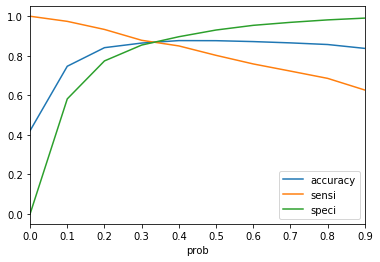

In [662]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

## From the above plot we see that the Accuracy, Sensi and speci intersect at 0.35 as cut off

In [663]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map( lambda x: 1 if x > 0.35 else 0)

y_train_pred_final.head()

Converted  Conversion_Prob  CustID  predicted  0.0  0.1  0.2  0.3  0.4  \
6708          1         0.950580    6708          1    1    1    1    1    1   
7289          1         0.990347    7289          1    1    1    1    1    1   
125           0         0.057982     125          0    1    0    0    0    0   
5721          0         0.401160    5721          0    1    1    1    1    1   
2121          1         0.764725    2121          1    1    1    1    1    1   

      0.5  0.6  0.7  0.8  0.9  final_predicted  
6708    1    1    1    1    1                1  
7289    1    1    1    1    1                1  
125     0    0    0    0    0                0  
5721    0    0    0    0    0                1  
2121    1    1    1    0    0                1

In [664]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.8715656345399041

In [665]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[2326,  329],
       [ 260, 1671]])

In [666]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [667]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8653547384774728

In [668]:
# Let us calculate specificity
TN / float(TN+FP)

0.8760828625235405

In [669]:
# Calculate false postive rate - predicting Converted when customer does not have converted
print(FP/ float(TN+FP))

0.12391713747645951


In [670]:
# Positive predictive value 
print (TP / float(TP+FP))

0.8355


In [671]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8994586233565351


In [672]:
## F1 Score

f1_score(y_train_pred_final['Converted'],y_train_pred_final['final_predicted'])

0.850165352327652

## Precision and recall tradeoff

In [673]:
y_train_pred_final.Converted, y_train_pred_final.predicted

(6708    1
 7289    1
 125     0
 5721    0
 2121    1
        ..
 8657    0
 88      1
 5612    0
 8577    0
 8211    1
 Name: Converted, Length: 4586, dtype: int64, 6708    1
 7289    1
 125     0
 5721    0
 2121    1
        ..
 8657    0
 88      1
 5612    0
 8577    0
 8211    1
 Name: predicted, Length: 4586, dtype: int64)

In [674]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

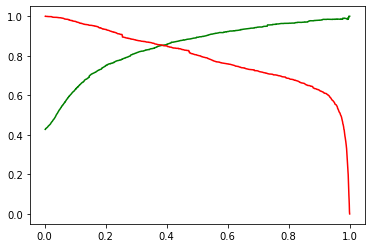

In [675]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

## Making predictions on the test set

In [676]:
X_test[[ 'TotalVisits','Total Time Spent on Website','Page Views Per Visit',
         'Asymmetrique Activity Score','Asymmetrique Profile Score']]=scaler.fit_transform(X_test[[ 'TotalVisits','Total Time Spent on Website','Page Views Per Visit',
                                                              'Asymmetrique Activity Score','Asymmetrique Profile Score']])

In [677]:
X_test = X_test[col]
X_test.head()

Total Time Spent on Website  Asymmetrique Activity Score  \
382                     -0.858648                    -0.157740   
6477                     1.004716                    -0.054333   
8565                    -1.025436                    -1.088398   
7708                    -0.831747                    -1.088398   
3077                     0.945533                     0.772919   

      Asymmetrique Profile Score  Lead Origin_Landing Page Submission  \
382                    -2.290790                                    1   
6477                    0.040630                                    1   
8565                   -0.957956                                    0   
7708                    1.041295                                    1   
3077                   -0.957956                                    0   

      Lead Origin_others  Lead Source_others  Last Activity_others  \
382                    0                   0                     0   
6477                   0                   0                     0   
8565                   0                   1                     0   
7708                   0                   0                     0   
3077                   0                   0                     0   

      What is your current occupation_others  \
382                                        0   
6477                                       0   
8565                                       0   
7708                                       0   
3077                                       0   

      Tags_Will revert after reading the email  Tags_others  \
382                                          0            0   
6477                                         0            0   
8565                                         0            0   
7708                                         0            0   
3077                                         1            0   

      Asymmetrique Activity Index_others  \
382                                    0   
6477                                   0   
8565                                   0   
7708                                   0   
3077                                   0   

      Asymmetrique Profile Index_02.Medium  Last Notable Activity_SMS Sent  \
382                                      1                               0   
6477                                     0                               1   
8565                                     1                               0   
7708                                     0                               0   
3077                                     1                               1   

      Last Notable Activity_others  
382                              0  
6477                             0  
8565                             0  
7708                             0  
3077                             0

In [678]:
X_test_sm = sm.add_constant(X_test)

In [679]:
y_test_pred = res.predict(X_test_sm)


In [680]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)


In [681]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [682]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [683]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

y_pred_final.head()

Converted         0
0          0  0.018931
1          1  0.412603
2          0  0.058106
3          0  0.023320
4          1  0.997265

In [684]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Conversion_Prob'})

y_pred_final

Converted  Conversion_Prob
0             0         0.018931
1             1         0.412603
2             0         0.058106
3             0         0.023320
4             1         0.997265
...         ...              ...
1961          1         0.021125
1962          1         0.279965
1963          1         0.991718
1964          0         0.222671
1965          0         0.236488

[1966 rows x 2 columns]

In [685]:
y_pred_final['final_predicted'] = y_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.35 else 0)

y_pred_final

Converted  Conversion_Prob  final_predicted
0             0         0.018931                0
1             1         0.412603                1
2             0         0.058106                0
3             0         0.023320                0
4             1         0.997265                1
...         ...              ...              ...
1961          1         0.021125                0
1962          1         0.279965                0
1963          1         0.991718                1
1964          0         0.222671                0
1965          0         0.236488                0

[1966 rows x 3 columns]

In [686]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.8596134282807731

In [687]:
confusion2 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_predicted )
confusion2

array([[960, 139],
       [137, 730]])

In [688]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [689]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8419838523644751

In [690]:
# Let us calculate specificity
TN / float(TN+FP)


0.8735213830755232

In [691]:
# Calculate false postive rate - predicting Converted when customer does not have converted
print(FP/ float(TN+FP))

0.1264786169244768


In [692]:
# Positive predictive value 
print (TP / float(TP+FP))

0.8400460299194477


In [693]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8751139471285324


In [694]:
## F1 Score

f1_score(y_pred_final['Converted'],y_pred_final['final_predicted'])

0.8410138248847927